In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import constants as const
import seaborn as sns
from sympy import sqrt
from pynverse import inversefunc

In [98]:
ra, dec, pmra, pmdec = np.loadtxt('keanu.dat', delimiter=' ', unpack=True)

In [99]:
ra *= u.degree
dec *= u.degree
pmra *= u.mas / u.yr
pmdec *= u.mas / u.yr

Text(0, 0.5, 'Dec (degrees)')

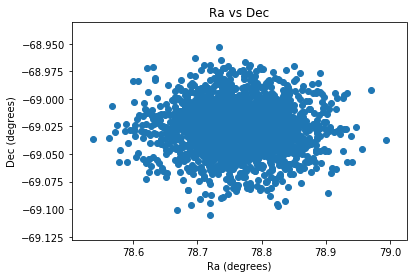

In [100]:
plt.scatter(ra, dec)
plt.title('Ra vs Dec')
plt.xlabel('Ra (degrees)')
plt.ylabel('Dec (degrees)')

Text(0, 0.5, 'PM in Dec (mas/yr)')

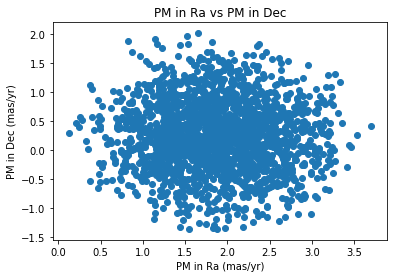

In [101]:
plt.scatter(pmra, pmdec)
plt.title('PM in Ra vs PM in Dec')
plt.xlabel('PM in Ra (mas/yr)')
plt.ylabel('PM in Dec (mas/yr)')

In [102]:
print(f'''Values obtained from dataset
-----------------------------------
Position of center:
Ra: {ra.mean():.3f}\tDec: {dec.mean():.3f}

Proper motion:
PM in Ra:   {pmra.mean():.3f}\t({(pmra.mean()*4.5*u.kpc).to(u.km/u.s, equivalencies=u.dimensionless_angles()):.3f})
PM in Dec: {pmdec.mean():.3f}\t({(pmdec.mean()*4.5*u.kpc).to(u.km/u.s, equivalencies=u.dimensionless_angles()):.3f})


Reference values from Vasiliev 2019
-----------------------------------
Position of center:
Ra: 6.024 deg\tDec: -72.081 deg

Proper motions:
PM in Ra:   5.237 mas / yr\t({(5.237*u.mas/u.yr*4.5*u.kpc).to(u.km/u.s, equivalencies=u.dimensionless_angles()):.3f})
PM in Dec: -2.524 mas / yr\t({(-2.524*u.mas/u.yr*4.5*u.kpc).to(u.km/u.s, equivalencies=u.dimensionless_angles()):.3f})
''')


Values obtained from dataset
-----------------------------------
Position of center:
Ra: 78.762 deg	Dec: -69.027 deg

Proper motion:
PM in Ra:   1.878 mas / yr	(40.057 km / s)
PM in Dec: 0.249 mas / yr	(5.306 km / s)


Reference values from Vasiliev 2019
-----------------------------------
Position of center:
Ra: 6.024 deg	Dec: -72.081 deg

Proper motions:
PM in Ra:   5.237 mas / yr	(111.716 km / s)
PM in Dec: -2.524 mas / yr	(-53.842 km / s)



In [103]:
# coordinate transformation
ra2 = ra - ra.mean()
dec2 = dec - dec.mean()
pmra2 = pmra - pmra.mean()
pmdec2 = pmdec - pmdec.mean()

In [104]:
# distances to center. C&O Eq. 1.8
angdists = np.sqrt(np.square(ra2 * np.cos(dec2)) + np.square(dec2))
# convert angular distances to distances in pc
dists2center = (angdists * 50 * u.kpc).to(u.pc, equivalencies=u.dimensionless_angles())

# getting total projected velocity
totprojvels = np.sqrt(np.square(pmra2 * np.cos(dec2)) + np.square(pmdec2))
totprojvels *= 50 * u.kpc
totprojvels = totprojvels.to(u.km / u.s, equivalencies=u.dimensionless_angles())

Text(0, 0.5, 'Total projected velocity (km/s)')

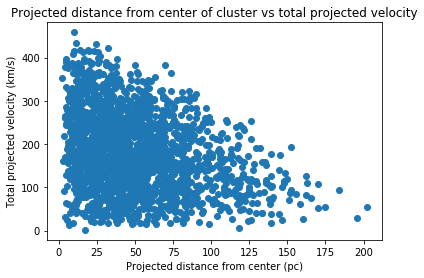

In [105]:
plt.scatter(dists2center, totprojvels)
plt.title('Projected distance from center of cluster vs total projected velocity')
plt.xlabel('Projected distance from center (pc)')
plt.ylabel('Total projected velocity (km/s)')

In [113]:
vsq = 3 * np.var(totprojvels)
vsq = vsq.to(u.m **2 / u.s ** 2)
r = np.max(abs(dists2center)).to(u.m)
mass = vsq * r / const.G
mass

<Quantity 2.22955874e+39 kg>

In [107]:
# calculating luminosity in terms of solar luminosity
lum = const.L_sun * 100 ** ((4.83 + 12.8) / 5)
# getting mass to light ratio with the sun as a baseline
mlratio = (mass / const.M_sun) / (lum / const.L_sun)
mlratio

<Quantity 99.47478503>

In [114]:
def einstein(ds, dd, m):
    dds = ds - dd
    return np.sqrt((4 * const.G * m * dds) / (ds * dd * const.c ** 2)) * u.rad

In [115]:
thetae = einstein(10 * u.kpc, 5 * u.kpc, 1 * u.M_sun).to(u.rad)
thetae

<Quantity 4.37511867e-09 rad>

In [117]:
def theta(beta, einstein):
    return (beta + np.sqrt(beta**2 + 4*einstein**2)) / 2, (beta - np.sqrt(beta**2 + 4*einstein**2)) / 2

In [118]:
xs = np.array([1, 10, 100, 1000])
for i in xs:
    y = np.min(np.abs(theta(i * thetae.value, thetae.value))) / thetae.value
    print(f'beta = {i}\t|theta|/theta_e in mas: {y*thetae.value:.3E}\tin terms of Einstein angle: {y:.3E}')

beta = 1	|theta|/theta_e in mas: 2.704E-09	in terms of Einstein angle: 6.180E-01
beta = 10	|theta|/theta_e in mas: 4.332E-10	in terms of Einstein angle: 9.902E-02
beta = 100	|theta|/theta_e in mas: 4.375E-11	in terms of Einstein angle: 9.999E-03
beta = 1000	|theta|/theta_e in mas: 4.375E-12	in terms of Einstein angle: 1.000E-03


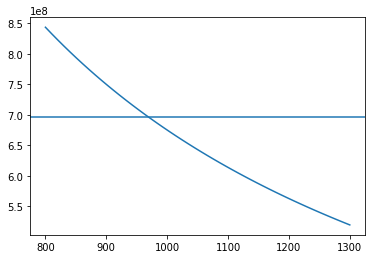

In [319]:
x = np.linspace(800, 1300)
y = [np.min(np.abs(theta(i*thetae.value, thetae.value))) * (5*u.kpc).to(u.m).value for i in x]
plt.plot(x, y)
plt.axhline(const.R_sun.value)

In [320]:
gety = lambda x: np.min(np.abs(theta(x*thetae.value, thetae.value))) * (5*u.kpc).to(u.m).value
getx = inversefunc(gety)

In [321]:
getx(const.R_sun.value) # beta

/usr/local/lib/python3.7/site-packages/pynverse/inverse.py:196: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  % accuracy, RuntimeWarning)


array(970.25954704)

In [325]:
gety(970.26) # checking

695699670.8571526

In [350]:
t = (const.R_sun / (5 * u.kpc)).to(u.dimensionless_unscaled)
b = t - thetae.value / t
b

<Quantity -970.26057156>

In [351]:
gety(-970.26) # doesnt matter. the += in the quadratic makes sure that you take the right one as the minimum one.

695699670.8571526

In [121]:
theta_ = np.min(np.abs(theta(-970.26*thetae.value, thetae.value))) * u.rad
theta_

<Quantity 4.50921817e-12 rad>

In [124]:
(970.26 * thetae).to(u.mas)

<Quantity 875.59464698 mas>

In [332]:
def magn(beta, einstein):
    return 1/4 * (beta / np.sqrt(beta**2 + 4 * einstein**2) + np.sqrt(beta**2 + 4*einstein**2) / beta + 2), 1/4 * (beta / np.sqrt(beta**2 + 4 * einstein**2) + np.sqrt(beta**2 + 4*einstein**2) / beta - 2)

In [341]:
ys2 = np.array([magn(i*thetae.value, thetae.value) for i in xs])
# limit of magnification is 1, 0

array([[1.17082039e+00, 1.70820393e-01],
       [1.00009614e+00, 9.61446024e-05],
       [1.00000001e+00, 9.99600158e-09],
       [1.00000000e+00, 9.99977878e-13]])